In [1]:
from PIL import Image
from model import AggMInterface
from data import DInterface
import yaml
import warnings
warnings.filterwarnings("ignore")

# 指定模型的超参数配置文件路径和checkpoint文件路径
config_path = "logs/dinov2_backbone_dinov2_large/lightning_logs/version_0/hparams.yaml"
checkpoint_path = "logs/dinov2_backbone_dinov2_large/lightning_logs/version_0/checkpoints/dinov2_backbone_epoch(07)_step(7816)_R1[88.7800]_R5[95.5400]_R10[96.6200].ckpt"

# 加载yaml文件，获取模型超参数配置
with open(config_path) as f:
    config = yaml.safe_load(f)

# 根据配置初始化数据模块
data_module = DInterface(**config)  # 数据模块初始化，传入配置参数
transform = data_module.valid_transform  # 获取验证集的数据变换方法

# 根据checkpoint文件路径加载模型，并设置为评估模式
model = AggMInterface.load_from_checkpoint(checkpoint_path)
model.eval()
model = model.model.model

/media/cartolab3/DataDisk/wuqilong_file/Projects/RerenkVPR/utils/hook_func.py:21: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


正在尝试从以下路径导入模块: .dinov2_backbone
正在查找类: Dinov2Backbone


In [12]:
# 实例化dino v2，不微调
from torch.hub import load
import torch
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

model_dino = load(
            # repo_or_dir="facebookresearch/dinov2",
            repo_or_dir='/home/cartolab3/.cache/torch/hub/facebookresearch_dinov2_main',
            model='dinov2_vitl14',
            trust_repo=True,
            source='local',
        )
model_dino.cuda()
model_dino.eval()
model_dino.requires_grad_(False)

def load_dino_v2(x):
    x = model_dino.prepare_tokens_with_masks(x)
    # 前向传播
    with torch.no_grad():
        for block in model_dino.blocks:
            x=block(x)
        # 获取最终输出
        x = model_dino.norm(x)
        x = x[:, 0]
        return x

In [13]:
from einops import rearrange
from utils.hook_func import extract_features
from visualization import get_pca_map
import numpy as np
import os
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.linewidth': 1.2,
    'lines.linewidth': 2.5,
    'lines.markersize': 10,
    'grid.linewidth': 0.8,
})

# 可视化单层的特征图
def visualize_dinov2_pca(model, input_image_path, facet_layer_and_facet={23: 'token'},save_path=None):
    # 定义加载图像并resize，输出tensor的transform
    ori_image = Image.open(input_image_path).convert("RGB")
    
    # 获取transform后的图像
    image = transform(ori_image).unsqueeze(0).cuda()
    image_size = (image.shape[2], image.shape[3])  # 获取transform后的图像尺寸
    print(f"Transformed image shape: {image.shape}")

    # 为模型注册hook以提取特征
    feats = extract_features(model, image, facet_layer_and_facet)
    print(f"Features shape: {feats[0].shape}")
    patch_tokens = feats[0][:,1:,:]
    print(f"Patch tokens shape: {patch_tokens.shape}")

    # 获取特征图
    features = patch_tokens.detach().cpu()
    features = rearrange(features, 'b (h w) c -> b h w c', 
                        h=int(image_size[0]/14), w=int(image_size[1]/14))
    features = features[0].float()

    # 生成PCA可视化图
    color = get_pca_map(features, image_size, interpolation='bilinear')
    color = (color*255).astype(np.uint8)
    print(f"PCA map shape: {color.shape}")

    # 拼接原始图像和PCA图
    image = np.hstack((ori_image.resize(image_size), color))
    print(f"Final image shape: {image.shape}")

    if save_path is not None:
        # 使用指定的保存路径
        rgb_image = Image.fromarray(image)
        rgb_image.save(save_path)
    else:
        # 使用 matplotlib 显示图像
        plt.figure(figsize=(8, 3))
        plt.imshow(image)
        plt.axis('off')
        plt.show()

In [14]:
# 一次可视化多个层的特征图
def visualize_dinov2_pca_multi_layers(model, input_image_path, facet_layers_and_facets={15: 'token', 23: 'token'}, save_path=None):
    # ... 保持原有图像加载和转换代码 ...
     # 定义加载图像并resize，输出tensor的transform
    ori_image = Image.open(input_image_path).convert("RGB")
    
    # 获取transform后的图像
    image = transform(ori_image).unsqueeze(0).cuda()
    image_size = (image.shape[2], image.shape[3])  # 获取transform后的图像尺寸
    print(f"Transformed image shape: {image.shape}")
    
    # 为每一层提取特征并生成PCA图
    all_pca_maps = []
    for layer, facet in facet_layers_and_facets.items():
        # 提取当前层的特征
        feats = extract_features(model, image, {layer: facet})
        patch_tokens = feats[0][:,1:,:]
        
        # 获取特征图
        features = patch_tokens.detach().cpu()
        features = rearrange(features, 'b (h w) c -> b h w c', 
                           h=int(image_size[0]/14), w=int(image_size[1]/14))
        features = features[0].float()

        # 生成PCA可视化图
        color = get_pca_map(features, image_size, interpolation='bilinear')
        color = (color*255).astype(np.uint8)
        all_pca_maps.append(color)
    
    # 创建包含原图和所有PCA图的组合图像
    num_maps = len(all_pca_maps) + 1  # +1 是为了包含原图
    # 创建图形和子图网格
    fig = plt.figure(figsize=(4*num_maps, 4))
    gs = fig.add_gridspec(1, num_maps, wspace=0.02)  # 使用GridSpec控制间距
    
    # 显示原图
    ax = fig.add_subplot(gs[0])
    ax.imshow(ori_image.resize(image_size))
    ax.set_title('Original')
    ax.axis('off')
    
    # 显示每个层的PCA图
    for idx, (layer, pca_map) in enumerate(zip(facet_layers_and_facets.keys(), all_pca_maps)):
        ax = fig.add_subplot(gs[idx+1])
        ax.imshow(pca_map)
        ax.set_title(f'Layer {layer}')
        ax.axis('off')
    
    # 调整整体布局
    plt.tight_layout(pad=0.5, w_pad=0.1)
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1, dpi=300)
        plt.close()
    else:
        plt.show()

Transformed image shape: torch.Size([1, 3, 560, 560])


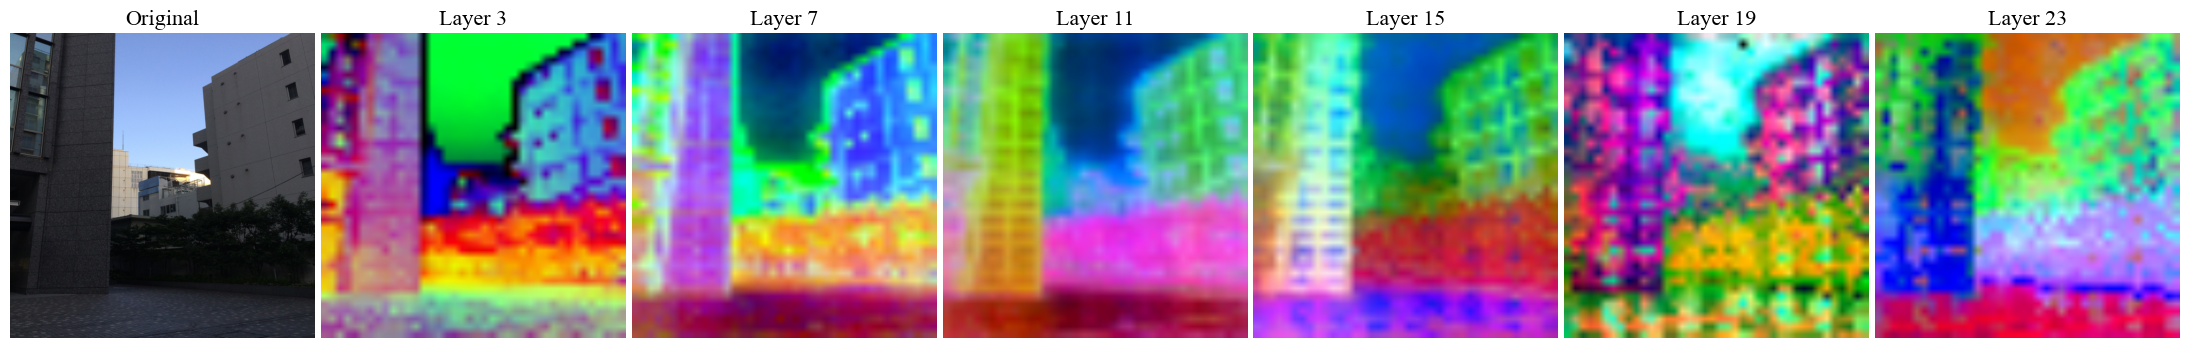

Transformed image shape: torch.Size([1, 3, 560, 560])


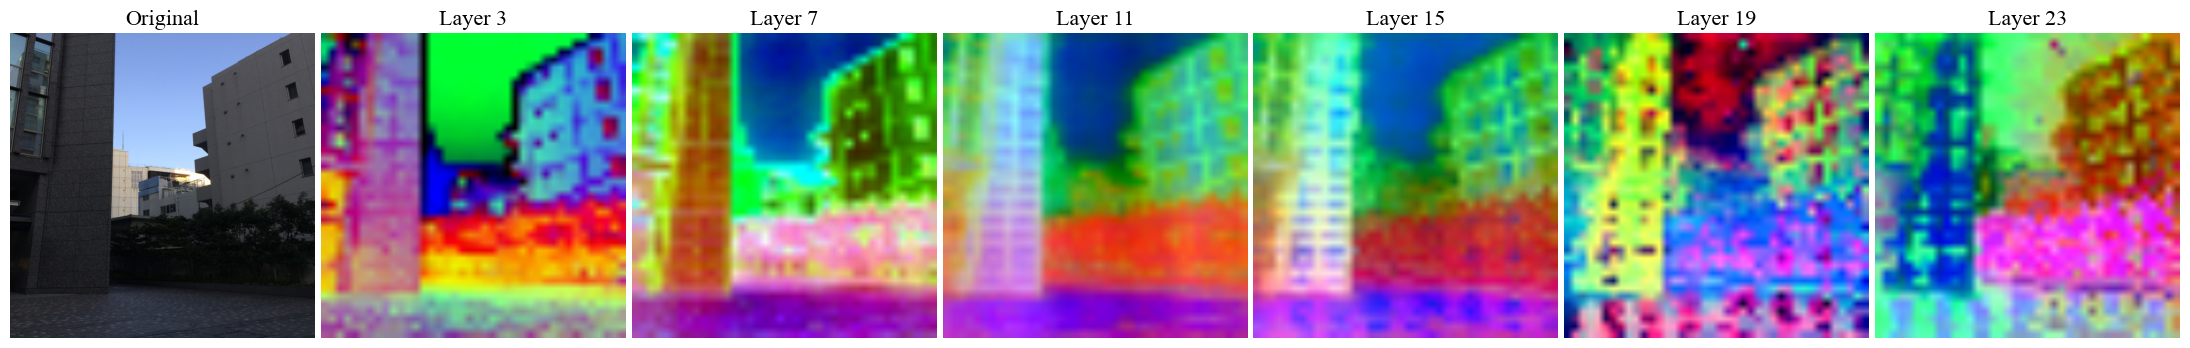

In [16]:
# 可视化单张图像
input_image_path = r"/media/cartolab3/DataDisk/wuqilong_file/Projects/RerenkVPR/tmp_imgs/00266.jpg"
layers=list(range(3,24,4))
facet_layers_and_facets = {layer: 'token' for layer in layers}
save_path=None  
visualize_dinov2_pca_multi_layers(
    model=model_dino,
    input_image_path=input_image_path,
    facet_layers_and_facets=facet_layers_and_facets,
    save_path=None
)

visualize_dinov2_pca_multi_layers(
    model=model,
    input_image_path=input_image_path,
    facet_layers_and_facets=facet_layers_and_facets,
    save_path=None
)

Transformed image shape: torch.Size([1, 3, 560, 560])


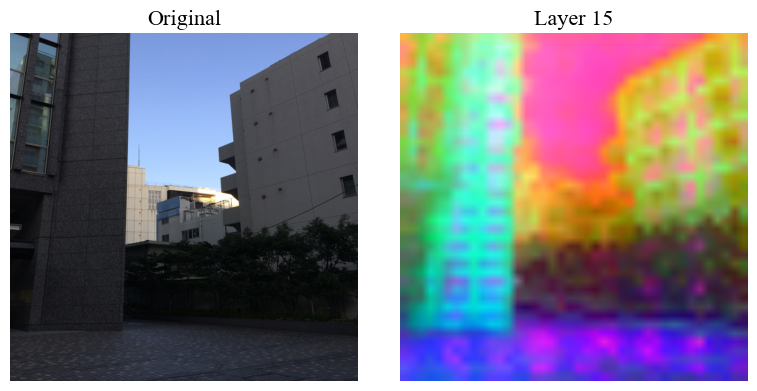

In [35]:
# 可视化单张图像
input_image_path = r"/media/cartolab3/DataDisk/wuqilong_file/Projects/RerenkVPR/tmp_imgs/00266.jpg"
facet_layer_and_facet = {15: 'token'}
save_path=None  
visualize_dinov2_pca(model, input_image_path, facet_layer_and_facet,save_path)

In [37]:
import glob

# 可视化多张图像
img_path = "/media/cartolab3/DataDisk/wuqilong_file/Projects/RerenkVPR/tmp_imgs"
image_list = glob.glob(os.path.join(img_path, "*.jpg"))
output_folder='some_result_images/layer_token_feats'
print(f"找到 {len(image_list)} 张图片")

for image_path in image_list:
    # 为每张图片生成对应的保存路径
    save_name = os.path.basename(image_path)
    save_name = f"dinov2_{save_name}"
    save_path = os.path.join(output_folder, save_name)
    
    # 调用可视化函数，注意传入所有必要参数
    visualize_dinov2_pca_multi_layers(
        model=model,
        input_image_path=image_path,
        facet_layers_and_facets=facet_layers_and_facets,
        save_path=save_path
    )

找到 17 张图片
Transformed image shape: torch.Size([1, 3, 560, 560])
Transformed image shape: torch.Size([1, 3, 560, 560])
Transformed image shape: torch.Size([1, 3, 560, 560])
Transformed image shape: torch.Size([1, 3, 560, 560])
Transformed image shape: torch.Size([1, 3, 560, 560])
Transformed image shape: torch.Size([1, 3, 560, 560])
Transformed image shape: torch.Size([1, 3, 560, 560])
Transformed image shape: torch.Size([1, 3, 560, 560])
Transformed image shape: torch.Size([1, 3, 560, 560])
Transformed image shape: torch.Size([1, 3, 560, 560])
Transformed image shape: torch.Size([1, 3, 560, 560])
Transformed image shape: torch.Size([1, 3, 560, 560])
Transformed image shape: torch.Size([1, 3, 560, 560])
Transformed image shape: torch.Size([1, 3, 560, 560])
Transformed image shape: torch.Size([1, 3, 560, 560])
Transformed image shape: torch.Size([1, 3, 560, 560])
Transformed image shape: torch.Size([1, 3, 560, 560])
